# Race Events

Simple attempts at identifying race related events.

In [71]:
#using notebook rather than inline enables 3D matplotlib plots
%matplotlib inline

import pandas as pd

In [4]:
url = 'http://fiawec.alkamelsystems.com/Results/08_2018-2019/07_SPA%20FRANCORCHAMPS/267_FIA%20WEC/201905041330_Race/Hour%206/23_Analysis_Race_Hour%206.CSV'


In [ ]:
laptimes = pd.read_csv(url, sep=';').dropna(how='all', axis=1)
laptimes.columns = [c.strip() for c in laptimes.columns]

#Tidy the data a little... car and driver number are not numbers
laptimes[['NUMBER','DRIVER_NUMBER']] = laptimes[['NUMBER','DRIVER_NUMBER']].astype(str)

## Core Enrichment

Really need to move the df enrichment into a utils fn before the tech debt gets too much!


In [8]:
#Add the parent dir to the import path
import sys
sys.path.append("..")

#Import contents of the utils.py package in the parent directory
from py.utils import *

#Get laptimes in seconds
laptimes['LAP_TIME_S'] = laptimes['LAP_TIME'].apply(getTime)

#Find accumulated time in seconds
laptimes['ELAPSED_S']=laptimes['ELAPSED'].apply(getTime)

#Find position based on accumulated laptime
laptimes = laptimes.sort_values('ELAPSED_S')
laptimes['POS'] = laptimes.groupby('LAP_NUMBER')['ELAPSED_S'].rank()

#Find leader naively
laptimes['leader'] = laptimes['POS']==1

#Find lead lap number
laptimes['LEAD_LAP_NUMBER'] = laptimes['leader'].cumsum()


laptimes.head()

,NUMBER,DRIVER_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,...,PIT_TIME,CLASS,GROUP,TEAM,MANUFACTURER,LAP_TIME_S,ELAPSED_S,POS,leader,LEAD_LAP_NUMBER
2381,7,1,1,2:00.155,0,NaN,33.767,0,56.631,0,...,NaN,LMP1,H,Toyota Gazoo Racing,Toyota,120.155,120.155,1.0,True,1
2876,8,1,1,2:01.977,0,NaN,34.280,0,57.610,0,...,NaN,LMP1,H,Toyota Gazoo Racing,Toyota,121.977,121.977,2.0,False,1
262,17,1,1,2:03.259,0,NaN,35.742,0,56.454,0,...,NaN,LMP1,NaN,SMP Racing,BR Engineering,123.259,123.259,3.0,False,1
777,3,2,1,2:03.739,0,NaN,36.035,0,56.644,0,...,NaN,LMP1,NaN,Rebellion Racing,Rebellion,123.739,123.739,4.0,False,1
130,11,3,1,2:05.631,0,NaN,37.247,0,57.103,0,...,NaN,LMP1,NaN,SMP Racing,BR Engineering,125.631,125.631,5.0,False,1


## LapTime Distribution

Eyeball the laptime distribution just to get a feel for it.

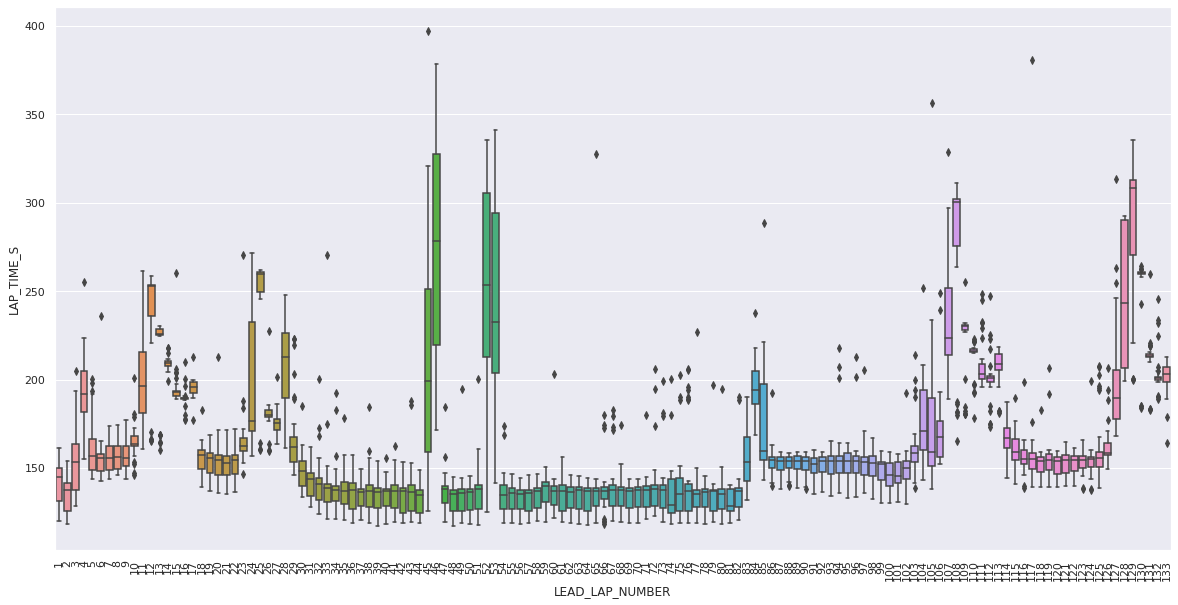

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(20,10)})

ax = sns.boxplot(x="LEAD_LAP_NUMBER", y="LAP_TIME_S", data=laptimes[laptimes['LAP_TIME_S']<500])
plt.xticks(rotation=90);

Can we get signal from the differerces between fastest lap time per lead lap?

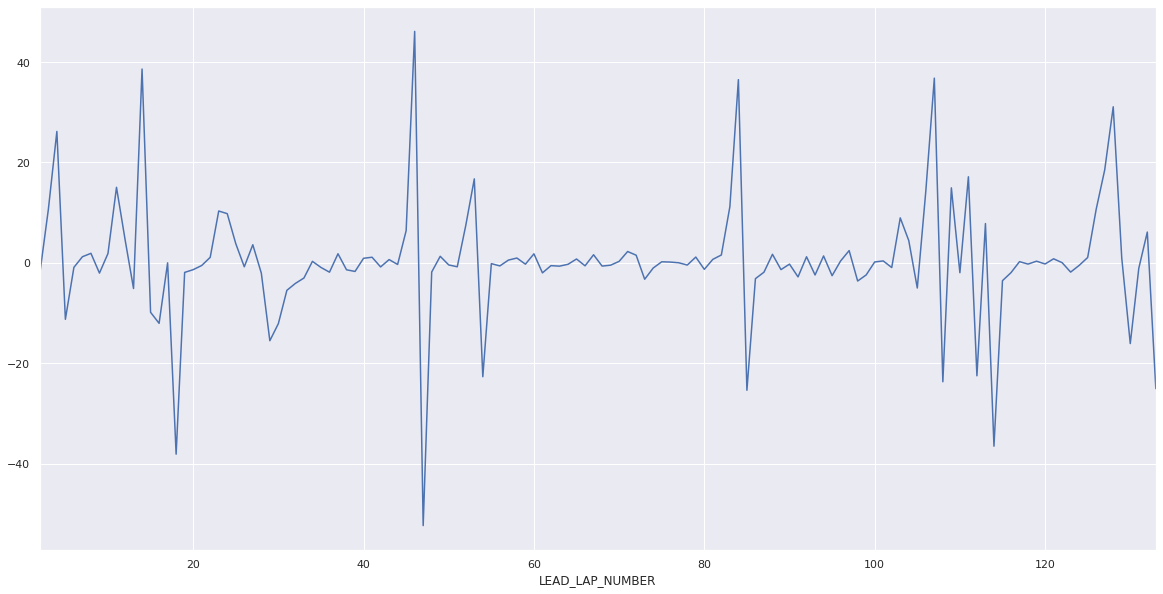

In [62]:
laptimes.groupby(['LEAD_LAP_NUMBER'])['LAP_TIME_S'].min().diff()[1:].plot()

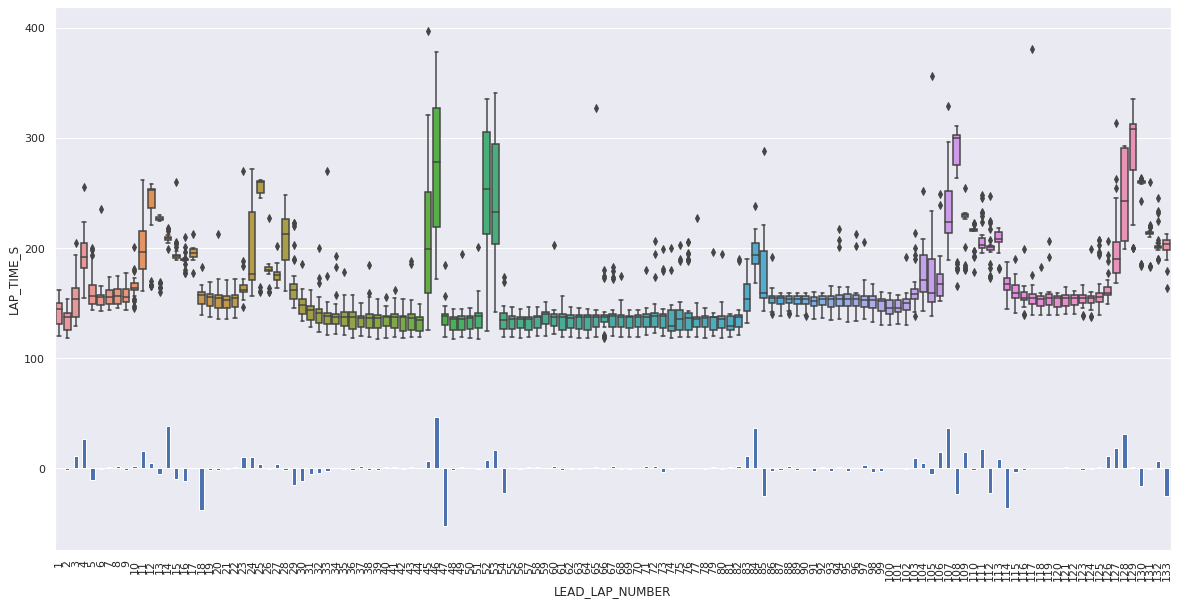

In [82]:
ax2 = laptimes.groupby(['LEAD_LAP_NUMBER'])['LAP_TIME_S'].min().diff().fillna(0).plot(kind='bar')
sns.boxplot(x="LEAD_LAP_NUMBER", y="LAP_TIME_S", data=laptimes[laptimes['LAP_TIME_S']<500], ax=ax2)
sns.set(rc={'figure.figsize':(20,10)})
ax2;

## Slow Laps

Slow laps may be a safety car, may be yellow flags, may be the weather...

Start by identifying median and standard deviation of laptimes on a per lead lap basis.

In [160]:
#pandas 0,25?
#laptimes_summary_stats = laptimes.groupby(['LEAD_LAP_NUMBER']).agg(median_lap_time_s=('LAP_TIME_S', 'median'),
#                                                                   sd_lap_time_s=('LAP_TIME_S', 'std'))

laptimes_summary_stats = laptimes.groupby(['LEAD_LAP_NUMBER']).agg({'LAP_TIME_S':['mean', 'median','std']})

laptimes_summary_stats.columns = laptimes_summary_stats.columns.get_level_values(1)

laptimes_summary_stats.head()

,mean,median,std
LEAD_LAP_NUMBER,,,
1,141.082912,144.699,12.183414
2,133.496618,137.736,9.691920
3,153.886636,153.401,18.891562
4,192.534118,191.853,20.749068
5,162.354806,156.618,16.789378


<IPython.core.display.Javascript object>


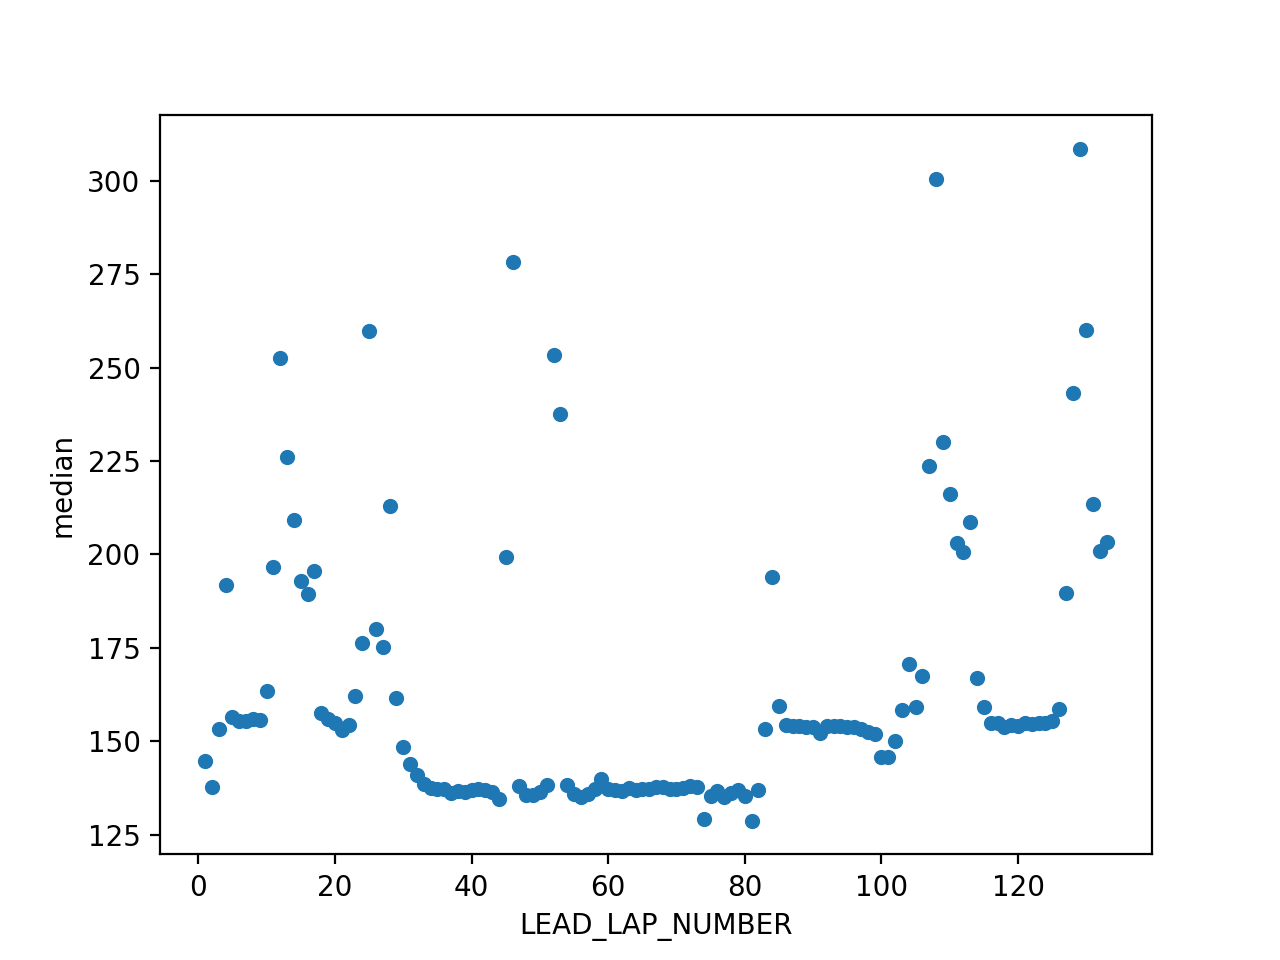

In [36]:
laptimes_summary_stats.reset_index().plot(kind='scatter', x='LEAD_LAP_NUMBER', y='median')

<IPython.core.display.Javascript object>


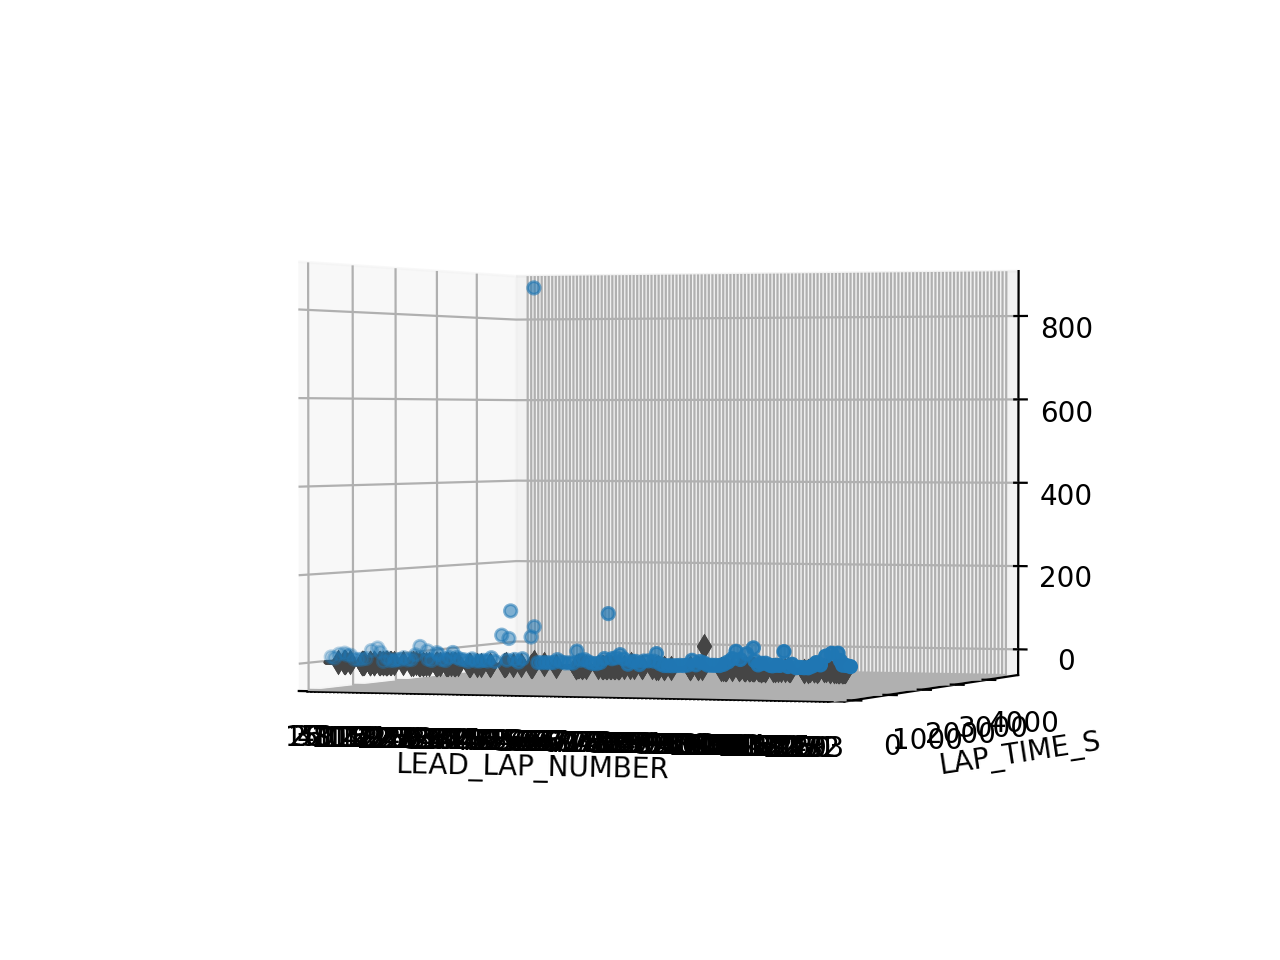

In [37]:
#laptimes_summary_stats.plot(kind='scatter', x='median', y='std')

%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D


scatter3d = plt.figure().gca(projection='3d')
scatter3d.scatter(laptimes_summary_stats.index, laptimes_summary_stats['median'], laptimes_summary_stats['std'])

## Pit Events Per Lap

Is there any signal to be had from pit events per lap?

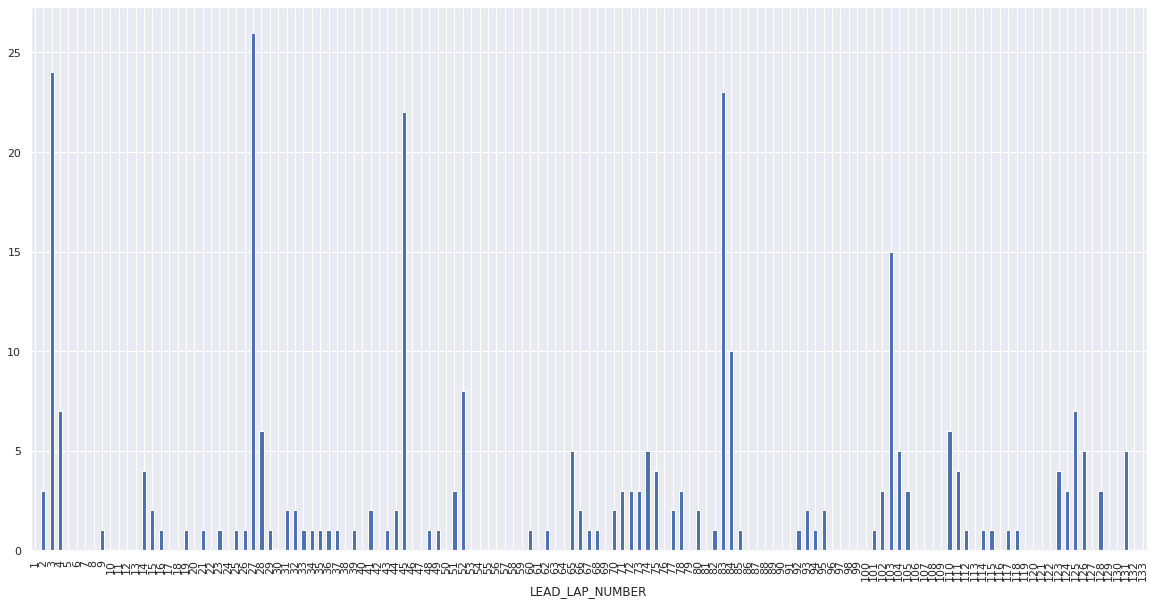

In [56]:
laptimes['INLAP'] = laptimes['CROSSING_FINISH_LINE_IN_PIT']== 'B'
laptimes.groupby('LEAD_LAP_NUMBER')['INLAP'].apply(lambda x: x.sum()).plot(kind='bar');

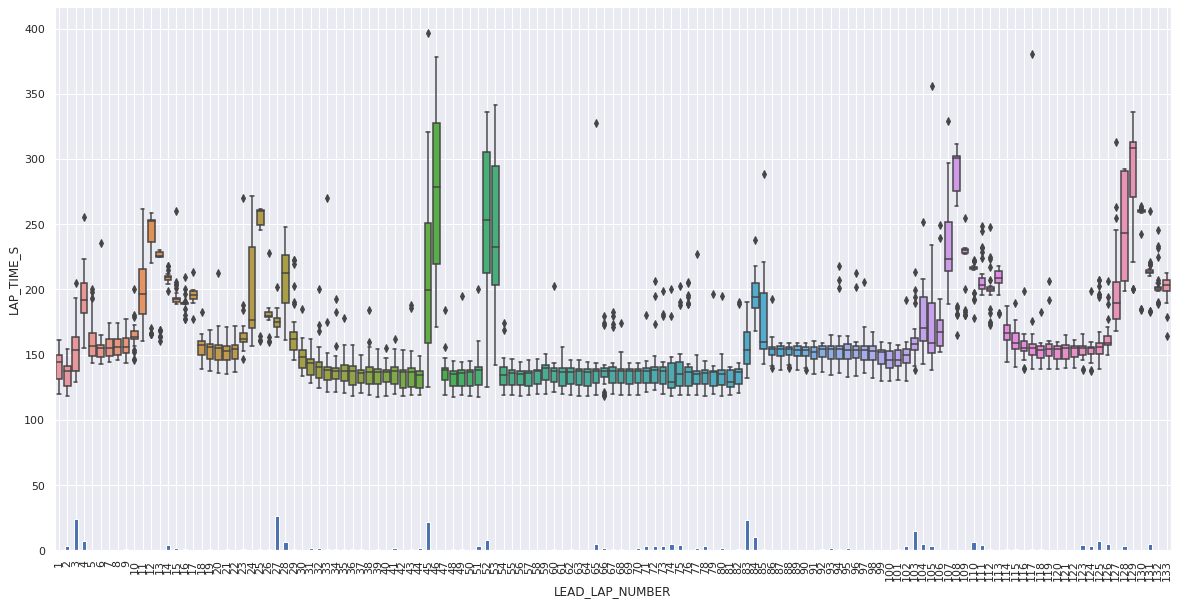

In [69]:
ax = sns.boxplot(x="LEAD_LAP_NUMBER", y="LAP_TIME_S", data=laptimes[laptimes['LAP_TIME_S']<500])
laptimes.groupby('LEAD_LAP_NUMBER')['INLAP'].apply(lambda x: x.sum()).plot(kind='bar', ax=ax);

## Simple Classifier

Can we build a simple K-means classifier with K=2 to identify slow laps? 

In [104]:
from sklearn.cluster import KMeans


In [211]:
from numpy import NaN

tmp = laptimes[['LEAD_LAP_NUMBER','NUMBER','LAP_TIME_S','INLAP']]

#Let's void times that are pit times
tmp.loc[tmp['INLAP'], 'LAP_TIME_S'] = NaN

#Also set overlong laptimes to NA
LONG_LAP_TIME = 400
tmp.loc[tmp['LAP_TIME_S'] > LONG_LAP_TIME, 'LAP_TIME_S'] = NaN


# Now create a table of car laptimes by leadlap

#Some cars may have multiple laptimes recorded on one lead lap
#in this case, we need to reduce the multiple times to a single time, eg min, or mean
car_by_lap = tmp.pivot_table(index='LEAD_LAP_NUMBER',columns='NUMBER', values='LAP_TIME_S', aggfunc='min')
car_by_lap.head()

NUMBER,1,11,17,26,28,29,3,31,36,37,...,81,82,86,88,90,91,92,95,97,98
LEAD_LAP_NUMBER,,,,,,,,,,,,,,,,,,,,,
1,126.349,125.631,123.259,130.204,132.841,129.335,123.739,132.132,131.763,134.179,...,144.903,145.413,161.521,150.242,151.430,147.990,146.417,145.979,144.495,155.734
2,120.417,120.443,120.213,125.028,127.616,124.843,120.193,126.243,125.979,127.074,...,137.703,138.048,NaN,137.769,141.434,138.023,137.991,NaN,NaN,146.244
3,NaN,128.686,129.886,NaN,NaN,NaN,NaN,134.128,NaN,NaN,...,NaN,NaN,NaN,153.401,NaN,NaN,NaN,186.104,193.661,NaN
4,190.094,NaN,NaN,187.287,184.219,179.956,182.981,NaN,223.294,218.998,...,216.436,192.175,255.287,NaN,205.041,205.334,191.531,154.871,156.304,198.729
5,149.763,184.800,191.934,148.890,147.842,148.768,143.637,200.416,149.113,147.908,...,155.872,155.208,163.185,NaN,166.379,161.079,155.048,154.323,155.312,162.983


In [212]:
#Fill na with row mean, though it requires a hack as per ??
#SHould we use mean, median, or min?

car_by_lap_clean = car_by_lap.T.fillna(car_by_lap.mean(axis=1)).T
car_by_lap_clean.head()

NUMBER,1,11,17,26,28,29,3,31,36,37,...,81,82,86,88,90,91,92,95,97,98
LEAD_LAP_NUMBER,,,,,,,,,,,,,,,,,,,,,
1,126.349000,125.631000,123.259000,130.204000,132.841000,129.335000,123.739000,132.132000,131.763000,134.179000,...,144.903000,145.413000,161.521000,150.242000,151.430000,147.990000,146.417000,145.979000,144.495000,155.734000
2,120.417000,120.443000,120.213000,125.028000,127.616000,124.843000,120.193000,126.243000,125.979000,127.074000,...,137.703000,138.048000,132.201097,137.769000,141.434000,138.023000,137.991000,132.201097,132.201097,146.244000
3,151.675222,128.686000,129.886000,151.675222,151.675222,151.675222,151.675222,134.128000,151.675222,151.675222,...,151.675222,151.675222,151.675222,153.401000,151.675222,151.675222,151.675222,186.104000,193.661000,151.675222
4,190.094000,197.135741,197.135741,187.287000,184.219000,179.956000,182.981000,197.135741,223.294000,218.998000,...,216.436000,192.175000,255.287000,197.135741,205.041000,205.334000,191.531000,154.871000,156.304000,198.729000
5,149.763000,184.800000,191.934000,148.890000,147.842000,148.768000,143.637000,200.416000,149.113000,147.908000,...,155.872000,155.208000,163.185000,162.354806,166.379000,161.079000,155.048000,154.323000,155.312000,162.983000


In [213]:
kmeans = KMeans(n_clusters=2, random_state=0).fit( car_by_lap_clean )

Now let's highlight clustered laps and see if we've picked out the slow ones...

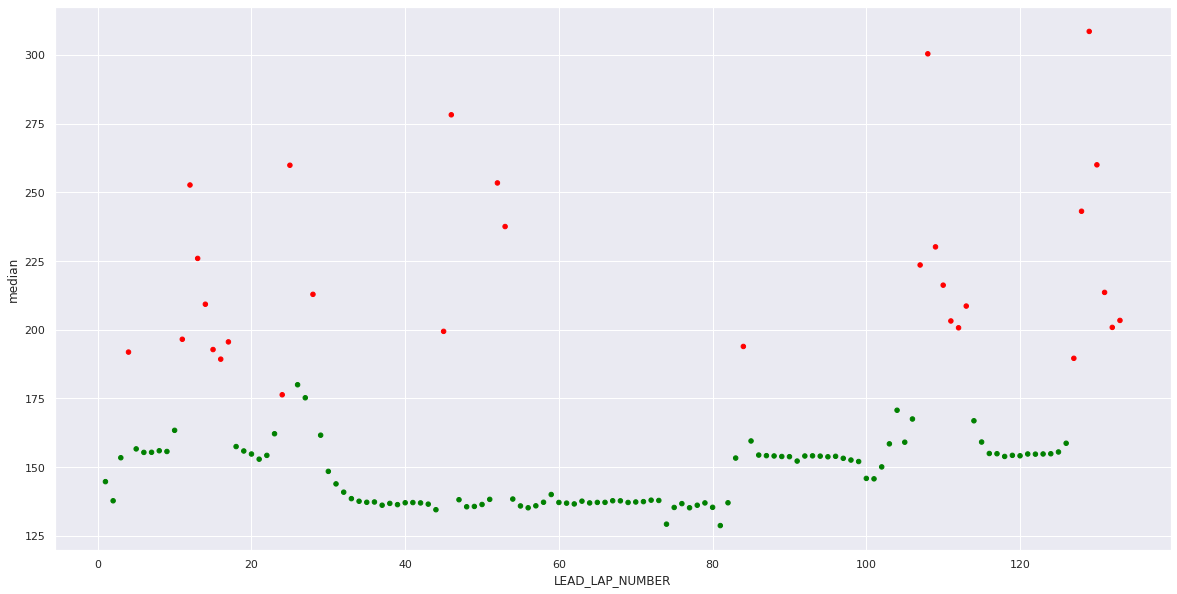

In [214]:
import numpy as np

laptimes_summary_stats['CLUSTER_GROUP'] = kmeans.labels_

colours = np.where(laptimes_summary_stats['CLUSTER_GROUP'], 'red', 'green')
#ax = sns.scatterplot(x="total_bill", y="tip", hue = 'CLUSTER_GROUP' data=tips)
laptimes_summary_stats.reset_index().plot(kind='scatter', x='LEAD_LAP_NUMBER', y='median', color=colours)

Seems to be pretty good, though around lap 25 a couple of misclassifications, perhaps?

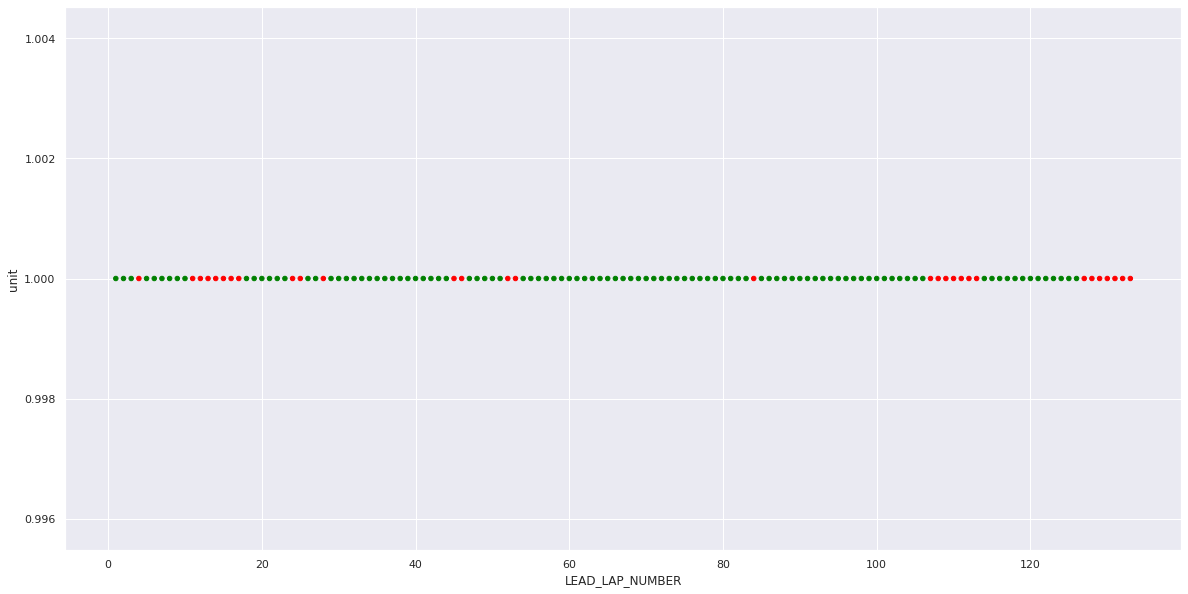

In [218]:
laptimes_summary_stats['unit']=1
laptimes_summary_stats.reset_index().plot(kind='scatter', x='LEAD_LAP_NUMBER', y='unit', color=colours)